# Agrupamiento de documentos

Autor: Eric S. Tellez <eric.tellez@infotec.mx> <br/>


## Introducción

Hasta el momento hemos visto operaciones de búsqueda de texto completo y de la búsqueda en espacios métricos.
Ambas operaciones son fundamentales en un sistema de recuperación de información, y de hecho, en otras áreas como son la inteligencia computacional.
También se vió la clasificación basada en vecinos cercanos como una herramienta para comparar modelos de texto.

Recordemos que el objetivo de la disciplina de Recuperación de Información es facilitar el acceso a las personas a grandes cúmulos de información,
de tal forma que seamos capaces de encontrar la información sobre la que se realizan consultas. En ese espíritu, el agrupamiento (clustering) y la visualización son de gran ayuda para obtener información de valor.

En el agrupamiento se parte una base de datos métrica (documentos o cualquier otro tipo de dato) de tal forma que los elementos en cada una de sus partes tengan cierta afinidad, por ejemplo que sean cercanos y compactos, o que pertenezcan a un grupo donde la densidad sea alta. Normalmente se intenta reducir una función de costo para cada grupo y de manera global.

Dado que los documentos suelen estar representados en muy alta dimensión, es prácticamente imposible visualizar y aprender sobre la estructura de una base de datos. Esto último lo podemos realizar mediante transformaciones que nos permitan obtener dimensiones que permitan la visualización de las estructuras subyacientes, i.e., dimensiones 2 y 3.

Recuerde que en la representación basada en bolsas de palabras es común encontrar vectores de decenas o cientos de miles de dimensiones, aunque sumamente dispersos. En las representaciones semánticas se encuentran en espacios densos de cientos de dimensiones. La distancia en ambos casos es comúnmente medida en términos de los ángulos de los vectores, ya que esto nos permité disociar las magnitudes que cambiarán con la cantidad de componentes y con el tamaño de los documentos. Lo último nos da ventajas ya que normalmente se desea recuperar documentos largos a partir de consultas pequeñas.

## Agrupamiento (clustering)

Existen diversos algoritmos de clustering que pueden apoyar en la tarea, todos ellos con diferentes características que lo hacen adecuado para ciertas tareas.
En particular, podemos mencionar algunos ejemplos paradigmáticos, como sigue:

- [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering): Intenta encontrar los $k$ centros $C$ que minimicen la suma de las distancias al cuadrado de todos los elementos de la base de datos a algún elemento en $C$. En su forma más simple, el algoritmo comienza con una muestra aleatoria de $k$ puntos y usa el [algoritmo de Lloyd](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) para refinar los $k$ puntos: en cada iteración, se genera una partición con los elementos más cercanos a cada uno de los centroides, y se usan para generar nuevos centroides. El algoritmo convergerá en algunas iteraciones ya que es bastante rápido. Tiene como desventaja que el usuario debe saber el número de grupos $k$ óptimo y que su calidad puede variar de manera dramática con diferentes formas de inicializar el algoritmo.

- [affinity propagation](https://en.wikipedia.org/wiki/Affinity_propagation): Usa tres matrices y un esquema basado en mensajes para obtener los elementos más adecuados para representar una base de datos. En este algoritmo no es necesario especificar $k$ ya que se calcula como parte del proceso. Las tres matrices son, la matriz de similitud, la matriz de reponsabilidad y de de disponibilidad. La idea es considerar a todos los elementos como posibles centros e intercambiar mensajes entre las matrices de responsabilidad y disponibilidad, usando la matriz de similitud como base de la información. El algoritmo es iterativo y se detendrá cuando no haya cambios en las matrices o se llegue a un límite en el número de las iteraciones. La estructura del cluster emergerá como parte este proceso.

- [DBSCAN](https://es.wikipedia.org/wiki/DBSCAN): Es un algoritmo que es especial para descubrir grupos en base a la densidad, de tal forma que para que dos puntos $u$ y $v$ pertenezcan al mismo grupo, no necesariamente son cercanos entre ellos, pero si que hay una serie de puntos $\{w_i\}$ en el mismo grupo con los que se puede trazar una ruta entre $u$ y $v$. Ahora, para que un elemento forme parte de un grupo debe cumplir que comparte al menos $\ell$ elementos en común con el grupo en un radio de búsqueda $\epsilon$, los puntos dentro de una ruta entonces cumplen con estas propiedades. A diferencia de los algoritmos basados en particiones compactas, las formas de los grupos en DBSCAN pueden ser caprichosas. No es necesario conocer el número de centros pero si $\ell$ y $\epsilon$.

## Proyecciones a baja dimensión
Una de las herramientas más importantes para el entendimiento de una colección de objetos, llamese documento o cualquier otro tipo de dato, es la visualización. La visualización consiste en obtener proyecciones en 2D o 3D y utilizar diferentes estrategias para que la información de valor sea _evidente_ a nuestros ojos.

En particular, podemos considerar dos formas primordiales de proyecciones: lineales y no-lineales. Las proyecciones lineales son eficientes de calcular pero solo podrán capturar información lineal en la proyección. Un ejemplo paradigmático es Principal Compontent Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)), que es ampliamente usado en ciencia de datos y que la gran mayoría de la paquetería para análisis de datos lo implementará ([PCA en sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [PCA en Julia](https://github.com/JuliaStats/MultivariateStats.jl)). En particular, cuando los datos podrían no ser proyectados de manera adecuada con transformaciones lineales, entonces se hace necesario el uso de transformaciones no lineales. En este caso podemos tener en cuenta Kernel PCA ([KPCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis)) cuya no linearidad es manejada por funciones kernel, i.e., realizando una proyección no-linear mediante el kernel antes de aplicar PCA.

La familia de métodos _manifold learning_ también pueden ser una opción. En estos casos, en lugar de analizar las componentes de los vectores, se hace uso de la matriz de afinidad $A$, i.e., matriz de distancias $d(u, v) \forall u, v \in X$, o el grafo de todos los $k$ vecinos cercanos $G$. En particular, estos métodos intentarán crear representaciones vectoriales de baja dimensión que repreduzcan hasta cierto nivel de precisión dicha matriz $A$ o $G$, esto es, que las relaciones topológicas se preserven. Entre estos métodos podemos encontrar [Isomap](https://en.wikipedia.org/wiki/Isomap), [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) o [UMAP](https://umap-learn.readthedocs.io/en/latest/).

En particular, es posible encontrar implementaciones de ellos en [sklearn](https://scikit-learn.org/stable/modules/manifold.html) y [UMAP](https://umap-learn.readthedocs.io/en/latest/) para Python; en Julia [ManifoldLearning.jl](https://github.com/wildart/ManifoldLearning.jl) y [SimSearchManifoldLearning.jl](https://github.com/sadit/SimSearchManifoldLearning.jl), donde también se puede acceder a una implementación eficiente de UMAP.


# Ejemplo


In [1]:
using Pkg
Pkg.activate(".")

using SimilaritySearch, SimSearchManifoldLearning, TextSearch, StatsBase, Clustering, Plots, LinearAlgebra, HypertextLiteral

  Activating project at `~/IR-2022/Unidades`


In [2]:
function create_index(vectors)
    dist = NormalizedCosineDistance()
    db = VectorDatabase(vectors)
    index = SearchGraph(; dist, db, verbose=false)
    index!(index)
    optimize!(index, MinRecall(0.9))
    index
end

function text_model_and_vectors(corpus;
        textconfig=TextConfig(group_usr=false, group_url=true, del_diac=true, del_punc=true, lc=true, group_num=true, nlist=[1], qlist=[]),
        model=VectorModel(IdfWeighting(), TfWeighting(), textconfig, corpus)
    )
    model = filter_tokens(model) do t
        5 ≤ t.ndocs ≤ 1000
    end
    vectors = vectorize_corpus(model, textconfig, corpus)
    (; textconfig, model, vectors)
end


text_model_and_vectors (generic function with 1 method)

In [3]:
include("read_datasets.jl")
D, _ = read_news()
T = text_model_and_vectors(D.corpus);

(textconfig = TextConfig(true, false, true, true, true, false, false, true, Int8[], Int8[1], Skipgram[], IdentityTokenTransformation()), model = {VectorModel global_weighting=IdfWeighting(), local_weighting=TfWeighting(), train-voc=11497, train-n=30244, maxoccs=996}, vectors = Dict{UInt32, Float32}[Dict(0x00001dc8 => 0.57991326, 0x00000181 => 0.31341138, 0x00000372 => 0.39686528, 0x00000770 => 0.4627978, 0x00001276 => 0.44021592), Dict(0x00000772 => 0.15711181, 0x0000139e => 0.23388581, 0x000010fc => 0.25397217, 0x000012b6 => 0.23673646, 0x00000c39 => 0.18115789, 0x00000a62 => 0.1956938, 0x0000027d => 0.12077178, 0x00000045 => 0.20731837, 0x00000205 => 0.17803536, 0x0000017e => 0.12767428…), Dict(0x00000d60 => 0.32544783, 0x00000006 => 0.17154841, 0x000000a4 => 0.34424198, 0x00002457 => 0.3763708, 0x000004a5 => 0.18201584, 0x00000014 => 0.16089603, 0x00000b10 => 0.29782277, 0x00000c75 => 0.26964122, 0x000005b9 => 0.20830649, 0x00001466 => 0.34424198…), Dict(0x0000125c => 0.479636, 0x00

In [4]:
@time index = create_index(T.vectors);

 11.124186 seconds (12.70 M allocations: 1.577 GiB, 7.98% gc time, 59.08% compilation time)


# Reducción de dimensión

In [5]:
function create_umap_embeddings(index; k=15, n_epochs=100, neg_sample_rate=3, tol=1e-3, layout=RandomLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="")
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

In [6]:
@info Threads.nthreads()
@time e2, e3 = create_umap_embeddings(index, k=15, tol=1e-3, layout=RandomLayout());

 13.883445 seconds (296.13 k allocations: 4.504 GiB, 2.40% gc time)
 28.780442 seconds (22.79 M allocations: 5.948 GiB, 3.37% gc time, 33.70% compilation time)


┌ Info: 64
└ @ Main In[6]:1
*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.255486528
- embedding init: 0.000411055
- embedding opt: 2.48311571



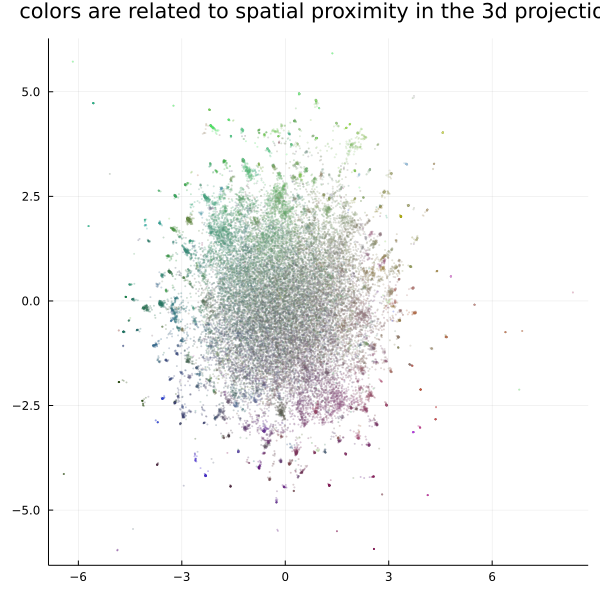

In [7]:
plot_umap(e2, e3)

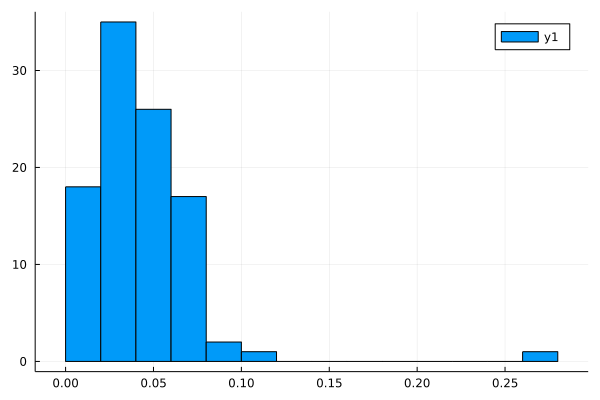

In [8]:
function compute_epsilon(emb; m=100, k=7)
    db = MatrixDatabase(emb)
    E = ExhaustiveSearch(; dist=L2Distance(), db)
    queries = rand(db, m)
    I, D = searchbatch(E, queries, k)
    histogram(last.(eachcol(D)))
end

compute_epsilon(e2)

# Clustering

In [9]:
clusters_ = dbscan(e2, 0.02, min_cluster_size=20)

99-element Vector{DbscanCluster}:
 DbscanCluster(92, [13, 340, 430, 747, 820, 944, 1103, 2057, 2218, 2676  …  27114, 27529, 28666, 29014, 29541, 29844, 29847, 29862, 29950, 30224], Int64[])
 DbscanCluster(38, [26, 117, 1438, 2198, 3063, 3174, 4244, 4811, 5122, 5605  …  24670, 25700, 25940, 25955, 26390, 27123, 27645, 28358, 29472, 30015], Int64[])
 DbscanCluster(30, [32, 396, 950, 3315, 3763, 7990, 9691, 10340, 10705, 11075  …  23065, 23771, 25256, 27212, 27505, 27949, 28145, 28669, 29652, 30194], Int64[])
 DbscanCluster(80, [35, 90, 348, 393, 1142, 1250, 1423, 1994, 2896, 2999  …  27173, 27305, 27541, 27583, 27677, 27914, 29281, 29507, 29774, 29871], Int64[])
 DbscanCluster(51, [39, 1003, 1139, 1888, 2048, 2196, 2507, 3155, 4041, 4236  …  24721, 25308, 25826, 26603, 27211, 27966, 29333, 29558, 29840, 30190], Int64[])
 DbscanCluster(25, [61, 1078, 3280, 3895, 5574, 6547, 7420, 8155, 9844, 11595  …  19335, 19563, 19613, 20598, 20803, 21201, 22905, 23545, 25241, 26735], Int64[])
 DbscanC

In [10]:
plot()

let res=KnnResult(20), voc=T.model.voc, bow=Dict{UInt32,Float32}()
    for c in clusters_
        X = @view e2[1, c.core_indices]
        Y = @view e2[2, c.core_indices]
        scatter!(X, Y, c=:auto, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="")
        if rand() < 0.3
            L = sort!(collect(countmap(D.labels[c.core_indices])), by=last, rev=true)
            L = [ "$k ($v); " for (k, v) in L]
            
            
            empty!(bow)
            S = []
            for i in c.core_indices
                V = T.vectors[i]
                length(V) == 1 && continue  # empty vectors 
                TextSearch.add!(bow, V)
                if length(S) < 7
                    push!(S, @htl """<li>$(D.corpus[i])</li>""")
                end
            end
            
            res = reuse!(res)
            for (tokenID, weight) in bow
                push!(res, tokenID, -weight)
            end
            
            LV = []
            for (id, weight) in res
                push!(LV, string(voc.token[id], " (", -round(weight; digits=2), "); "))
            end
            
            display(@htl """
            <div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
                CLUSTER LABELS ($(length(c.core_indices))): <span style="background-color: rgb(60, 60, 10);">$(L)</span>
            <div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
                VOC: $(LV)
                <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
                <ul> $S </ul>
                </div>
            </div>
            </div>
            """)
            
            # @show C[c.core_indices, :]  # cut text
        end
    end
end


<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (92): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (92); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: _espect (28.58); @univ (24.25); #enportada (3.4); famosos (1.59); https (1.45); actriz (1.42); #tienesquever (1.36); serie (1.25); the (1.25); vida (1.24); cuando (1.2); detras (1.17); estrena (1.14); rivera (1.1); belinda (1.07); #alfombraroja (1.0); dice (0.95); cantante (0.91); #notaplus (0.9); cdmx (0.9); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @Univ_espect: #TomaNota De acuerdo a la promotora, los boletos adquiridos en las fechas anteriores se respetarán para las nuevas que ser…</li><li>RT @Univ_espect: Harvey Weinstein será trasladado a California para enfrentar más acusaciones  https://t.co/SgDbKPR7PU https://t.co/zUrxjye…</li><li>RT @Univ_espect: #Entérate El &quot;nuevo&quot; Círculo Teatral supera la pandemia y eleva la ilusión https://t.co/usPpSBii1R https://t.co/8ITZh1zUfe</li><li>RT @Univ_espect: El productor Toño Berumen suma 10 denuncias por acoso, abuso y violación 
https://t.co/XBY3Xne2Zp https://t.co/ESYNPlmhHw</li><li>RT @Univ_espect: Regresa a la Tierra el equipo cinematográfico ruso que filmó en el espacio  https://t.co/03CAh0viBN https://t.co/LnksQnzsuz</li><li>RT @Univ_espect: .@SebastianYatra se despide del miedo con &quot;Tacones Rojos&quot; https://t.co/SThwP3u0nk https://t.co/Yk3wUth10b</li><li>RT @Univ_espect: #EnPortada El director Benito Fernández presenta &quot;Uma &amp;amp; Hagen&quot;, cinta en la que se imagina un mundo prehispánico con tecno…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (31): <span style="background-color: rgb(60, 60, 10);">AdriDelgadoRuiz (31); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: 📻 (11.66); 🗞 (6.19); #heraldoradio (5.5); 📲 (5.16); #eldedoenlallaga (4.92); @heraldodemexico (4.65); 🎙 (4.53); 📺 (4.11); fm (1.58); #periodismo (1.33); #mexico (1.08); #noticias (0.97); #veracruz (0.74); @adridelgadoruiz (0.73); _nacional (0.73); @pri (0.72); abogado (0.68); general (0.63); columnista (0.62); herramientas (0.57); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>“Solo en un caso hace falta cumplir las órdenes de aprehensión”

@JesusRCuevas , coordinador General de Comunicación Social de la Presidencia de la República

#ElDedoEnLaLlaga 
#HeraldoRadio📻🎙
@heraldodemexico 🗞📻📺📲
#periodistasasesinados https://t.co/htkLWs53gc</li><li>#ElDedoEnLaLlaga

#EsMomento de hablar de cine con Gonzalo Lira @Gonyz , crítico de cine y tv, quien hoy nos trae en #Exclusiva una #Entrevista con #ClaireDanes y #TomHiddleston de la serie #TheEssexSerpent

#HeraldoRadio📻
@heraldodemexico 🗞📻📺📲
#cine #TV #periodismo #Mexico https://t.co/p3jDjOaK5h</li><li>Tomás Mundo, abogado de la familia Moreno Vásquez

#HeraldoRadio📻🎙
@heraldodemexico 🗞📻📺📲</li><li>#PlanDeEstudios2022 #EducaciónBásica

“Es muy impactante lo que les afectó a los niños -la pandemia-, ver inhibido su proceso de socialización”

Claudia Amilpas Morales, profesora de 6to año de primaria 

#ElDedoEnLaLLaga en el 98.5 FM 📻🎙
#HeraldoRadio 🗞📻📺📲 https://t.co/gJ2RweniWK</li><li>#ElDedoEnLaLlaga   #SomosDébito

&quot;Las #mujeres arriba de los 50 años son las que recurren más a las asistencias médicas de Check Up y de consulta las mujeres de 40 son más del Check Up y psicológica&quot;:  Laura Rubio, @BancoAzteca
#HeraldoRadio📻🎙 
@heraldodemexico
 🗞📻📺📲 https://t.co/06wfUdZjBZ</li><li>“Hoy tenemos mejores herramientas para atender otra posible ola de #COVIDー19 “

Dr. Jorge Salas, Director del @RespiraINER
#ElDedoEnLaLlaga 
#HeraldoRadio📻🎙
@heraldodemexico 🗞📻📺📲 https://t.co/A0Ke0FkVPb</li><li>“La exigencia a las autoridades es que dejen de simular que nos apoyan”

Mirna Medina, fundadora de “ @LasRastreadoras del fuerte Sinaloa” 

#ElDedoEnLaLlaga
#HeraldoRadio📻🎙
@heraldodemexico 🗞📻📺📲

#PersonasDesaparecidas #HastaEncontrarles #BuscandoNosEncontramos #Mexico https://t.co/Bzdst9AfwM</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (26): <span style="background-color: rgb(60, 60, 10);">AdriDelgadoRuiz (26); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: #podcast (6.51); escucha (5.22); #eldedoenlallaga (5.0); #heraldoradio (4.34); @heraldodemexico (4.17); _prieto (1.3); @samuel (1.17); #periodista (1.0); #entrevista (0.98); #mexico (0.84); #justicia (0.75); utilizo (0.65); #opinionescompletas (0.63); realizamos (0.63); #onu (0.63); #omicron (0.62); fundamental (0.59); #migracion (0.59); analista (0.58); #economia (0.57); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Los seres vivos somos #energia y cuando se extingue una #especie se descompensa todo
Escucha la #Entrevista que le realizamos a César Menchaca en #podcast #ElDedoEnLaLLaga
#HeraldoRadio @heraldodemexico #pintura #escultura #ArteHuichol https://t.co/TRt1sZnntL</li><li>En el #DíaDeLosInocentes se recuerda la maldad del ser humano y la inocencia de las personas 
Escucha a @PadreJosedejesu
#podcast #ElDedoEnLaLlaga @heraldodemexico https://t.co/OYS4PZjvkx</li><li>¿La #Moda puede respetar ideologías de otros países? #PinedaCovalin utilizó estampados inspirados en #México en #DubaiFashionWeek en #ExpoDubai2020 y creó look que cubrió #escote y cabeza con mascadas
#Entrevista #RicardoCovalín diseñador @pinedacovalin #Podcast #ElDedoEnLaLlaga https://t.co/HoWA7u6qPC</li><li>Si continúa la tendencia al alza en la inflación y afecta a productores, invariablemente afectará a los consumidores. 
Escucha a Rodolfo Sánchez Arriola, consultor de temas financieros
#podcast #ElDedoEnLaLLaga
#HeraldoRadio @heraldodemexico https://t.co/d1TXpySnWe</li><li>¿Cómo afecta la #Impunidad en la impartición de #Justicia?
Escucha la conversación con #LucyDíazGenao, directora del colectivo Solecito de Veracruz @solecitodever
#podcast #ElDedoEnLaLLaga #HeraldoRadio @heraldodemexico https://t.co/NDK89CW9At</li><li>Entre los analistas, el consenso general es que la única salida para mejorar el balance financiero de@Pemex es una #reformafiscal
Lee y escucha la columna “Pemex: La encrucijada”
#podcast #ElDedoEnLaLlaga #OpinionesCompletas
#HeraldoRadio @heraldodemexico #Pemex https://t.co/b9RsNLTkln</li><li>Con las modificaciones se elimina a la #UIF como sujeto obligado a notificar a las personas que sus cuentas han sido congeladas. ¿La #UIF tendrá más facultades de #congelarcuentas?
Escucha en nuestro #podcast @ALEIDAALAVEZ Vicecoordinadora de @PartidoMorenaMx 
@heraldodemexico https://t.co/RXrHenv4XL</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">PublimetroChile (4); CNNEE (4); Milenio (2); bbcmundo (2); el_pais (2); NTN24 (1); El_Universal_Mx (1); teleSURtv (1); EFEnoticias (1); AdriDelgadoRuiz (1); AristeguiOnline (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: bar (0.97); tomo (0.67); tener (0.65); podia (0.64); verdaderamente (0.59); culiacan (0.59); valenzuela (0.57); gatos (0.57); decision (0.56); ofrenda (0.56); varias (0.54); balacera (0.53); boxeador (0.52); polly (0.49); acaba (0.48); mueren (0.48); vacunarse (0.48); tijuana (0.47); cuenca (0.47); alfredo (0.47); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La película “El Páramo” nos trae la historia de una madre y un hijo que deben enfrentar a una terrible criatura. 👇
https://t.co/dNFtARJFZT</li><li>&quot;Fue terrorífico, la habitación daba vueltas sin parar. Cuando regresé a EE UU apenas podía trabajar dos horas al día, no podía conducir y olvidaba cosas&quot;. El síndrome La Habana, la misteriosa dolencia que ataca a los espías y diplomáticos estadounidenses https://t.co/bFBUBJG7Cv</li><li>Conozca los riesgos que enfrenta al tener activo el Bluetooth en su celular https://t.co/sChg73qgSi</li><li>En 1613 fue publicada la novela &quot;El licenciado Vidriera&quot;, libro que ocupa el cuarto lugar entre las 5 obras más leídas de Cervantes, en la cual describe 3 elementos enlazados: un caso de locura, varias facetas de su vida militar y sátira de sus costumbres https://t.co/AUb0xUnqWv</li><li>Kahseim Outlaw acaba de perder su trabajo en Wallingford, Connecticut, EE.UU. por no vacunarse. https://t.co/qZrqroTmaW</li><li>¿No logras sentirte cómodo en el gimnasio? No estás solo. Muchas personas experimentan la sensación de no sentirse incluidas o bienvenidas. Pero hay acciones que pueden llevar adelante los centros deportivos para que eso cambie.
https://t.co/2yEm7llpZV</li><li>Jeffrey Smith se suicidó días después del ataque del 6 de enero al Capitolio. Tras meses de lucha de su viuda, su fallecimiento fue declarado muerte en cumplimiento del deber. Esto &quot;va a ayudar a muchas familias en el futuro&quot;, dice su abogado.
https://t.co/m88Oe5Mwx5</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (86): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (85); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: @vive (22.56); _usa (22.56); o (1.35); expertos (1.34); si (1.23); hasta (1.2); estos (1.16); htt (1.01); hombre (0.99); viaje (0.96); carrera (0.95); tienen (0.95); alimentos (0.94); tratamientos (0.92); deben (0.86); tiene (0.85); aerolineas (0.85); son (0.85); durante (0.83); https (0.82); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @Vive_USA: Las solicitudes de las becas deben ser hechas por las instituciones elegibles y canadienses postsecundarias. 

https://t.co/h…</li><li>RT @Vive_USA: Para que tu estancia sea lo más placentera posible, conviene respetar las leyes y así evitar problemas con las autoridades de…</li><li>RT @Vive_USA: El acceso a algunos de los cursos está disponible durante todo el año; toma nota. https://t.co/eIk4Ps21PK</li><li>RT @Vive_USA: Del consumo de estos alimentos depende una buena salud cardíaca o un riesgo mayor de muerte por problemas del corazón. 
https…</li><li>RT @Vive_USA: Hay múltiples maneras de emigrar y uno de los procesos más eficientes es mediante las visas de inversión https://t.co/jezjjzS…</li><li>RT @Vive_USA: Presentaron un informe de los trabajos mejor pagados en el área de Houston-The Woodlands-Sugar Land. 

https://t.co/wMNUlXJ7KI</li><li>RT @Vive_USA: El oficial de inmigración es quien tiene la decisión final sobre el ingreso de una persona a Canadá
https://t.co/LJlGLvT0Ep</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (20): <span style="background-color: rgb(60, 60, 10);">Reforma (3); PublimetroCol (2); epigmenioibarra (2); bbcmundo (2); Radio_Formula (2); NTN24 (1); PublimetroMX (1); Milenio (1); LaRazon_mx (1); CNNEE (1); azucenau (1); teleSURtv (1); el_pais (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: proyecto (0.77); hija (0.74); autos (0.71); #europa (0.65); @snietocastillo (0.57); viva (0.57); intentaban (0.57); sacar (0.55); destacar (0.53); cree (0.52); demasiado (0.5); chica (0.5); durante (0.49); ley (0.48); prohiben (0.47); amor (0.47); musicos (0.47); alma (0.47); estas (0.46); principios (0.45); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La hija dijo que su padre había evadido la justicia durante demasiado tiempo. https://t.co/fKn3tSPFtm</li><li>La madre llevaba un bulto en un pareo. Era su hija. Intentaban llevársela de la residencia para someter a su hija a una mutilación genital. Lo intentaban por segunda vez en su primer año de vida. Tanto ella como su marido fueron detenidos horas después https://t.co/4E92qKXsxh</li><li>La obra de #AlejoCarpentier es una de las más importantes dentro de la literatura latinoamericana de todos los tiempos

Conoce más sobre este escritor cubano → https://t.co/ZjLoz5pSdl https://t.co/vFJhXoj0si</li><li>#Meta va por sacar a #Facebook e #Instagram de #Europa https://t.co/rg4s46Gv0G https://t.co/3AUDKOkWdk</li><li>#Chile El proyecto estipula que la ley de matrimonio se amplíe para las parejas del mismo sexo y que éstas gocen de iguales derechos que las heterosexuales, entre ellos la adopción y filiación paternal de los hijos https://t.co/DHS3BOx8fV https://t.co/PhOCBtatcN</li><li>Su visión perturbadora de la naturaleza humana han conectado con muchos públicos alrededor del mundo. https://t.co/UkAPpbJHes</li><li>La “chica del clima” sabe destacar su figura con bikinis interesantes y alternativos.
https://t.co/GQXNpMl79E</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (60): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (23); julioastillero (13); AdriDelgadoRuiz (6); El_Universal_Mx (4); PublimetroChile (3); azucenau (3); RicardoAlemanMx (3); PublimetroCol (2); SinEmbargoMX (1); PublimetroMX (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul>  </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (27): <span style="background-color: rgb(60, 60, 10);">abc_es (4); PublimetroCol (3); Milenio (2); LaRazon_mx (2); azucenau (2); AristeguiOnline (2); NTN24 (1); SinEmbargoMX (1); PublimetroChile (1); El_Universal_Mx (1); bbcmundo (1); teleSURtv (1); EFEnoticias (1); Reforma (1); el_pais (1); AdriDelgadoRuiz (1); Radio_Formula (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: pesos (0.87); millones (0.7); investiga (0.63); cristo (0.6); ano (0.59); autores (0.58); camion (0.58); tunden (0.56); roban (0.55); @adelgadoleon (0.55); propone (0.54); plazo (0.54); cerca (0.52); feliz (0.52); leer (0.5); fiscalia (0.49); #tomanota (0.49); repeticion (0.49); largo (0.49); sudamerica (0.49); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>LaLiga saca músculo y blinda su futuro https://t.co/HwQviJcdtB

Tebas y su equipo cierran acuerdos históricos para el contexto a medio y largo plazo del fútbol español</li><li>¡El director de Acolfuturo explicó por qué ellos anunciaron el cese de actividades y contó la posición que tomó el club, que está en la mala! &quot;Este equipo está embargado por la DIAN en siete mil millones de pesos...&quot; https://t.co/OZcosVawkP</li><li>El gobernador de Morelos sustituyó a Pablo Ojeda y a José Manuel Sanz el pasado 3 de mayo.
https://t.co/HXW7Ehkpp2</li><li>#PegasusProject | En México urge garantizar verdad, justicia y no repetición en el caso #GobiernoEspía: R3D https://t.co/j13d2I3mcm https://t.co/eyMIVt4nvV</li><li>#AzucenaALas10 | En #QuintanaRoo, 8 personas murieron y al menos 14 más resultaron lesionadas luego de que un camión de pasajeros chocara con un camión de las obras del #trenmaya https://t.co/z4V2ALBRIP</li><li>🎓 &quot;Fue como ganarme la lotería&quot;: 284 graduados saltan de alegría por el regalo que les hizo el fundador de Snapchat. 

https://t.co/fIEV9wTJxe</li><li>RT @famamilenio: Nerea Godínez conmovió a todos con su mensaje en el que lamenta que el actor no haya visto todos sus regalos 🥺💔

https://t…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (20): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (6); Milenio (6); LaRazon_mx (2); Radio_Formula (2); PublimetroCol (2); EFEnoticias (1); el_pais (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: casos (3.18); nuevos (2.95); mil (2.78); coronavirus (1.68); @eluniversaloax (1.49); registra (1.43); horas (1.34); covid0 (1.26); covid (1.12); #quenosetepase (1.05); oaxaca (1.04); suma (0.99); #ultimahora (0.97); supera (0.94); dia (0.9); activos (0.89); solo (0.79); decesos (0.78); 🚨 (0.78); 🚩 (0.74); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @ElUniversalOax: #QueNoSeTePase ➡️ Celebran colectivas feministas de Oaxaca decisión de la Corte de despenalizar el aborto en todo el pa…</li><li>RT @ElUniversalOax: 🚩 Extrabajadores de Salud exigen recontratación inmediata y aguinaldo 2021; bloquean aeropuerto de Oaxaca

https://t.co…</li><li>RT @ElUniversalOax: ⚠️ Roban a mano armada nómina y aguinaldo de un grupo de trabajadores de Ixtepec, en el Istmo de Oaxaca

https://t.co/9…</li><li>🚨 #ÚLTIMAHORA | COVID anda ‘bravo’: suman 16,214 nuevos casos y 23 fallecidos adicionales.
https://t.co/yn5OBTCwMk https://t.co/x22XbGLXJQ</li><li>#ÚLTIMAHORA | Por tercer día consecutivo, México registra más de 12 mil casos nuevos de covid-19 en 24 horas https://t.co/sN0IHeAIQ5 https://t.co/okdCShT6ZH</li><li>300,000 decesos por #Covid en México https://t.co/tG3vBrbgHE https://t.co/HTgZi1qmi6</li><li>México suma más de 4 mil nuevos casos de coronavirus en 24 horas
https://t.co/naWIeuidWl https://t.co/kGkrEWtSmU</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (4); SinEmbargoMX (3); bbcmundo (3); abc_es (3); el_pais (2); AristeguiOnline (2); NTN24 (1); Radio_Formula (1); CNNEE (1); Milenio (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: viruela (7.91); mono (7.87); casos (1.92); oms (1.55); brote (1.01); caso (0.87); vacunar (0.73); espana (0.72); confirma (0.69); sintomas (0.64); ser (0.64); confirmados (0.64); primeros (0.64); elevan (0.63); virus (0.62); expertos (0.6); sanidad (0.6); tienes (0.6); reino (0.56); paises (0.56); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Detectan los primeros casos de viruela del mono en Colombia https://t.co/epDB1CjKLM</li><li>¿El virus de la viruela del mono se está adaptando al ser humano? Expertos investigan
 https://t.co/Dz8vql8toG https://t.co/0BOLfPC3iz</li><li>🔴#ÚLTIMAHORA | SSA confirma primer caso | México detecta caso importado de viruela del mono en hombre de 50 años. Está estable
 https://t.co/WLp8Chy2Wm https://t.co/SWs0ErTDdn</li><li>¿Qué es la viruela del mono, la extraña infección de la que hay casos en Reino Unido?  https://t.co/LaQ2GQsi4I https://t.co/fJazkicog4</li><li>España suma 59 casos de viruela del mono, casi todos en Madrid

https://t.co/oEFf4zUh1F https://t.co/HRkan8ab8d</li><li>Si tienes dudas en torno a qué es, cómo se contagia y cuál es su tratamiento, aquí resolvemos 7 preguntas sobre la viruela del mono.
https://t.co/DdjRPEho0X</li><li>El primer caso detectado en Argentina de viruela del mono proviene de España https://t.co/Y08yDLsWRL</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (35): <span style="background-color: rgb(60, 60, 10);">el_pais (35); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: _pais (10.68); _madrid (10.23); @el (9.71); madrid (1.66); unos (0.73); ultima (0.72); hora (0.68); puedan (0.64); ayuso (0.6); si (0.57); desde (0.56); local (0.54); muy (0.53); 🔴 (0.52); via (0.51); hoy (0.5); informatico (0.47); exclusivo (0.46); newsletter (0.46); quedara (0.46); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @el_pais_madrid: “La situación en primaria es indignante. Salí de allí en septiembre porque de cinco a nueve de la noche éramos dos médi…</li><li>RT @el_pais_madrid: Se llaman Moruno, Gordo y Antiguo y eran tres variedades de tomate del campo madrileño. Tras décadas perdidas, las pued…</li><li>RT @el_pais_madrid: “¿Cómo se va a pagar el alquiler si se está diciendo que no se use?”, se queja una fuente de la confianza del president…</li><li>RT @el_pais_madrid: —El miércoles vimos al señor Ossorio mirando al suelo buscando pobres. Busquen, mejor, dónde está su vergüenza.

La fra…</li><li>RT @el_pais_madrid: El cine Paz, la mítica sala con cinco pantallas en la calle de Fuencarral, en mitad del tramo entre las glorietas de Qu…</li><li>RT @el_pais_madrid: Almudena Lastra, fiscal superior: &quot;La Fiscalía entiende que hay delito y ese procedimiento está abierto. La Audiencia h…</li><li>RT @el_pais_madrid: 🔴ÚLTIMA HORA | El Gobierno de Madrid rebaja las medidas anticovid: menos pruebas diagnósticas y más libertad en las pis…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (25): <span style="background-color: rgb(60, 60, 10);">Milenio (25); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: siguelo (6.97); @mileniotv (6.71); #envivo (5.51); tiene (2.55); velazquez (2.28); cesar (1.96); #cdmx (1.88); reporte (1.62); plazas (1.38); cuenta (1.34); leer (1.27); detalles (0.94); isabel (0.8); reportan (0.76); informacion (0.73); #chiapas (0.72); te (0.69); lopez (0.67); diferentes (0.62); protestan (0.61); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#ENVIVO | Se reportan al menos 22 lesionados por explosión de edificio en avenida Coyoacán, #CdMx

César Velázquez tiene el reporte 

Síguelo por @mileniotv 
https://t.co/70LaSIGNCA</li><li>#ENVIVO | Padres de menor presuntamente abusado por diputado Saúl Huerta exigen desafuero y justicia 

César Velázquez tiene la información

Síguelo por @mileniotv 

https://t.co/NypLGX6uC1</li><li>#ENVIVO | Joe Biden habla sobre situación en #Ucrania

Síguelo por @mileniotv https://t.co/A7e2UIrXj6</li><li>#ENVIVO | #ÚLTIMAHORA 

En #CdMx detienen a Alejandro Del Valle, presidente de #Interjet 

Rubén Mosso tiene los detalles 

Síguelo por @mileniotv
https://t.co/wm5Mg93ALG</li><li>#ENVIVO | En #Chihuahua, bombardearán nubes para provocar lluvias y terminar la sequía 
 
Edson Calderón tiene el reporte
 
Síguelo por @mileniotv 
https://t.co/0sluB57Acz</li><li>#ENVIVO | #META21

Llega la secretaria de gobernación, Olga Sánchez Cordero, a emitir su voto en la alcaldía #MiguelHidalgo
César Velázquez tiene la información de las #Elecciones2021
 
Síguelo por @mileniotv 
https://t.co/WtAAllOk2s</li><li>#ENVIVO | Se reportan severas lluvias en #Nayarit debido a la llegada del huracán #Pamela, piden tomar precauciones

Salvador Arellano tiene el reporte

Síguelo en @mileniotv  
 
https://t.co/6j6keU88dA</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (22): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (4); el_pais (3); Milenio (2); bbcmundo (2); LaRazon_mx (2); PublimetroMX (1); PublimetroChile (1); PublimetroCol (1); epigmenioibarra (1); azucenau (1); Reforma (1); Radio_Formula (1); abc_es (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: quitarse (0.65); #palacionacional (0.64); nada (0.63); dic (0.62); invitados (0.58); ninos (0.57); rubio (0.57); estrena (0.54); pasar (0.53); conseguir (0.52); estilo (0.5); llegan (0.5); mejora (0.5); derecho (0.49); podran (0.48); taxistas (0.47); @elpaiscatalunya (0.47); govern (0.47); twitter (0.47); ninas (0.47); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>En los internados se buscaba asimilar a los niños indígenas de Canadá, que dejaran atrás su cultura y lengua.

https://t.co/N03lveptir</li><li>Japón aprobará la píldora del día después con el consentimiento de la pareja https://t.co/LUZmhabhgS

En el país nipón se llevaron a cabo 145.000 abortos quirúrgicos en 2020</li><li>ENTREVISTA | Consejera andaluza partidaria consultar a las bases para coalición de PP y Cs.

https://t.co/6Fvu7rdY72 https://t.co/IbgDqnzQWC</li><li>Olallo Rubio estrena sátira al estilo mexicano

https://t.co/Vhga064RRp https://t.co/TcaSfJOERi</li><li>En febrero de 2015, Nemtsov fue baleado a pocos metros del Kremlin. ¿Quién ordenó el asesinato y por qué?
https://t.co/Ogg72BTcWn</li><li>#AzucenaxMilenio | #EmilioLozoya podría pasar hasta 35 años en prisión... tiene hasta el 3 de diciembre para probar sus acusaciones 

¿A qué personajes señaló el exdirector de #Pemex? https://t.co/tmf0Qc6fLf</li><li>RT @famamilenio: Kimberly Loaiza sorprendió a todos sus seguidores con su hermoso outfit de catsuit plateado y mostró una sola de sus piern…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (108): <span style="background-color: rgb(60, 60, 10);">julioastillero (16); AdriDelgadoRuiz (12); epigmenioibarra (9); el_pais (8); Milenio (6); Reforma (6); PublimetroCol (5); bbcmundo (5); abrahamendieta (5); azucenau (5); UniNoticias (5); CNNEE (4); Radio_Formula (4); TelemundoNews (4); PublimetroMX (2); LaRazon_mx (2); teleSURtv (2); EFEnoticias (2); NTN24 (1); SinEmbargoMX (1); PublimetroChile (1); El_Universal_Mx (1); RicardoAlemanMx (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: gracias (29.28); querido (1.53); le (1.45); solidaridad (1.39); tu (1.36); accion (1.32); apoyo (1.24); poco (1.2); ya (1.2); mexicanos (1.17); ser (1.13); vida (1.11); todos (1.09); companeros (1.02); sueno (0.98); suministros (0.98); @epigmenioibarra (0.96); amenazar (0.95); sobrevivio (0.94); pasado (0.92); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @uriluisni: Gracias @julioastillero por la recomendación de #DontLookUp y sí,
siempre seguiremos mirando hacia arriba #LookUp</li><li>Mil gracias</li><li>RT @rafael_aldrich: @epigmenioibarra @CelesteSaenzM @HLGatell Me uno a @epigmenioibarra y a muchos mexican@s #AgradezcoAGatell GRACIAS DR.…</li><li>🎥 Gracias a la fundación Make-A-Wish y al departamento de policía de Dakota del Norte, el pequeño Cooper Craig, de 7 años de edad, pudo cumplir su sueño. https://t.co/hr163VnsJu</li><li>El tren &quot;Maglev&quot; de levitación magnética parece estar &quot;flotando&quot; gracias a una fuerza electromagnética que lo impulsa deslizándose sobre las vías. https://t.co/XcOMmfk8h6</li><li>Y todavía hay ingenuos que afirman que AMLO es el Presidente gracias al INE; no se equivoquen, es gracias a 30 millones de mexicanos que votamos por él y a pesar del INE.</li><li>#AzucenaxMilenio | Gracias a los habitantes de #Morelia,  pobladores de #Aguililla, #Michoacán han logrado tener algo qué comer https://t.co/lI5dYMVDiM</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (24): <span style="background-color: rgb(60, 60, 10);">teleSURtv (24); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: @iramsytelesur (7.79); #china (7.52); #eeuu (2.28); hoy (1.07); reitera (0.81); ratifica (0.77); tomara (0.73); nucleares (0.71); beijing (0.68); rechaza (0.68); acuso (0.66); pacifico (0.63); cooperacion (0.62); canciller (0.59); e (0.57); medidas (0.53); asegura (0.52); aseguro (0.5); d (0.5); politica (0.5); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @IramsyteleSUR: Hoy abrió en #China la Convención de las partes de la ONU sobre la Diversidad Biológica #COP15 con objetivo de combatir…</li><li>RT @IramsyteleSUR: Canciller de #China Wang Yi coopreside hoy de forma virtual con Alto Representante para la Política Exterior de la #Unió…</li><li>RT @IramsyteleSUR: #China exigió a #EEUU que responda positivamente a las preocupaciones &quot;razonables&quot; de Irán sobre cuestiones nucleares, d…</li><li>RT @IramsyteleSUR: #China reitera apoyo a todas las medidas que sean constructivas para restaurar la estabilidad en #Kazakhstan y continuar…</li><li>RT @IramsyteleSUR: #China defiende estrategia frente a Covid19 y rechaza politización de la pandemia por parte de #EEUU al responder al anu…</li><li>RT @IramsyteleSUR: #China llamó a #EEUU a mostrar sinceridad y presentar un plan realista para el diálogo con #CoreadelNorte
-Líder norcore…</li><li>RT @IramsyteleSUR: #China pidió también a EEUU detener represión y persecución contra sus empresas y aseguró que tomará medidas necesarias…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (34): <span style="background-color: rgb(60, 60, 10);">julioastillero (33); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: participacion (9.19); completa (9.06); ve (9.05); 🚢 (9.02); #astilleroinforma (8.97); 📺 (7.35); o (6.18); entrevista (4.98); 🏼 (3.35); 👉 (2.16); @adituzita (1.14); adriana (0.79); mexicana (0.73); mesa (0.72); @lavillegas0 (0.65); segmento (0.6); @temoris (0.59); caso (0.57); beneficio (0.57); jose (0.55); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🚢 Participación de @monerohernandez en #AstilleroInforma 

📺 Ve la entrevista completa en https://t.co/mGlD36klsu o en https://t.co/recOGr34nb https://t.co/6I0mQ16rY5</li><li>🚢 Participación de @LaVillegas1 en #AstilleroInforma 

👉🏼 Nuevo encierro por pandemia sería una noticia terrible para la economía mexicana: Claudia Villegas

📺 Ve la entrevista completa en https://t.co/bO1npArIfD o en https://t.co/recOGr34nb https://t.co/mqXC6cFeyk</li><li>🚢 Participación de @KenniaV en #AstilleroInforma 

👉🏼 Promovían un mayor consumo de azúcar con Peña Nieto y otros gobiernos

📺 Ve la entrevista completa en https://t.co/GEGBdfqXtd o en https://t.co/recOGr34nb https://t.co/cpdTnYP1B6</li><li>🚢 Participación de @monocordio en #AstilleroInforma 

📺 Ve la #MesaDelMásAllá completa en https://t.co/JRtj3x2XCF o en https://t.co/recOGr34nb https://t.co/uNuz8Huof6</li><li>🚢 Segmento con @adituzita en  #AstilleroInforma 

👉🏼 Voz de México es atendida respecto a Cumbre de las Américas: Adriana y Julio

📺 Ve el segmento completo en https://t.co/bEHDmDLrFk o en https://t.co/recOGrkFeJ https://t.co/LeIfm2ox2g</li><li>🚢 Participación de @Ricar_peralta en #AstilleroInforma 

📺 Ve la entrevista completa en https://t.co/UMcVYVtR66 o en https://t.co/recOGr34nb https://t.co/DkF9tCY55A</li><li>🚢 Participación de @HoracioFranco en #AstilleroInforma 

📺 Ve la #MesaDelMásAllá completa en https://t.co/1cSi34hMfj o en https://t.co/recOGr34nb https://t.co/dT3XvUe48c</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (27): <span style="background-color: rgb(60, 60, 10);">RicardoAlemanMx (27); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: #itinerariopolitico (8.85); @opinionlsr (8.6); 🇽 (5.77); 🇲 (5.71); eleccion (1.2); fracaso (0.99); ✍ (0.94); @lopezobrador (0.87); amlo (0.72); @ricardoalemanmx (0.71); 🗳 (0.67); electorales (0.64); era (0.64); resulta (0.63); construccion (0.62); #elecciones0 (0.61); michoacan (0.58); operaciones (0.56); #amlo (0.55); l (0.54); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 Los mexicanos seremos testigos de la amputación de uno de nuestros derechos fundamentales: la norma c…</li><li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 La destrucción del #NAIM y la construcción del #AIFA son hasta hoy los mayores monumentos a los preju…</li><li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 A 40 meses de gobierno la preocupación no era la violencia, tampoco la debacle económica, menos los f…</li><li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 La elección presidencial de 1988 no era una batalla más por el poder presidencial; en realidad era “l…</li><li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 Si hoy #AMLO se mantuviera en la trinchera de aquel eficaz opositor, sin duda habría exigido todo el…</li><li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 #Elecciones2021🗳️ Resulta que los mexicanos vivimos “la última llamada” para impedir la muerte de la…</li><li>RT @OpinionLSR: #ItinerarioPolítico🇲🇽 Apenas en el primer año de gobierno de AMLO, Mauricio Merino llamó a “despertar del sueño” y deslizó…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (67): <span style="background-color: rgb(60, 60, 10);">teleSURtv (65); UniNoticias (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: 🇻 (15.75); #venezuela (15.0); 🇪 (14.17); @nicolasmaduro (8.15); #envivo (4.61); siguelo (3.8); aqui (3.12); 📲 (3.11); expresa (1.72); → (1.58); pais (1.58); parte (1.52); ➡ (1.41); nacional (1.41); gobierno (1.24); regionales (1.21); aniversario (1.21); politica (1.19); @delcyrodriguezv (1.18); venezolanos (1.08); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#ENVIVO🔴| Presidente de #Venezuela 🇻🇪, @NicolasMaduro, indica que la causa #Palestina es la causa más noble que tiene la humanidad →https://t.co/tqMKHfl0b4 https://t.co/71lou6mv41</li><li>#ENVIVO | El actual secretario de la #OPEP, Mohamad Barkindo, expresa su agradecimiento al presidente de #Venezuela🇻🇪 por su liderazgo dentro de la organización 

Síguelo aquí https://t.co/tqMKHfl0b4 https://t.co/twSBrVVqrc</li><li>#ENVIVO | El presidente de #Venezuela🇻🇪 @NicolasMaduro: tienen que garantizar que el turismo aporte al nuevo mundo y al ingreso nacional para convertirlo en vida para el pueblo

Síguelo aquí📲https://t.co/76CeA67olK https://t.co/QkHXg2PPht</li><li>#ENVIVO | El presidente de #Venezuela🇻🇪 @NicolasMaduro: nos sumamos al repudio general de nuestro continente a la discriminación, a los actos de exclusión de los Estados Unidos de Noteamérica

Síguelo aquí📲https://t.co/M4XIACuwjS https://t.co/sPnWSEopYV</li><li>🇻🇪Con la presencia de opositores, #Venezuela se alista para elecciones municipales y regionales.

Pese a que por primera vez en años habrá más de 300 observadores internacionales, hay incertidumbre sobre si predominará la abstención.
https://t.co/L1jE5EDlhU</li><li>#ENVIVO | El presidente de #Venezuela🇻🇪, @NicolasMaduro, brinda declaraciones en el marco del encuentro de activistas del Movimiento #SomosVenezuela

👉https://t.co/tqMKHfl0b4 https://t.co/ticuwZ8B9p</li><li>#ENVIDEO📹| El dirigente de Primero Justicia, Henrique Capriles, ejerció su derecho al voto, en el marco de las elecciones regionales de #Venezuela🇻🇪 https://t.co/zITHW9W1iS</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">AristeguiOnline (3); TelemundoNews (3); CNNEE (2); EFEnoticias (2); el_pais (2); Radio_Formula (2); abc_es (2); NTN24 (1); PublimetroMX (1); bbcmundo (1); RicardoAlemanMx (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: rusia (3.43); otan (2.75); ucrania (2.27); conflicto (1.84); guerra (1.37); ucranianos (1.32); entre (1.13); ruso (1.06); europa (0.89); medio (0.77); claves (0.72); biden (0.71); volodymyr (0.66); kazajistan (0.61); #ucrania (0.59); limbo (0.56); impondra (0.55); putin (0.55); china (0.55); preparando (0.53); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>&quot;Actualmente, Europa occidental, incluyendo España, como país democrático y civilizado, y como miembro de la OTAN, está en guerra con una Rusia agresiva&quot;. Entrevista a Andréi Kozirev, exministro de Exteriores ruso https://t.co/5bLD1cIOLE</li><li>¿Es seguro viajar a Europa en medio del conflicto entre Rusia y Ucrania?

https://t.co/pe2gNyy99N</li><li>📌 Biden advierte al presidente ucraniano Volodymyr Zelenskyy que existe una “clara posibilidad” de que los rusos puedan invadir Ucrania en febrero.

https://t.co/9IHEQjFB6e</li><li>China sigue el ejemplo del gobierno de AMLO y no impondrá sanciones a Rusia.
https://t.co/yfznjdfhFL</li><li>Rusia y Ucrania: el limbo de las familias estadounidenses que adoptaron a niños ucranianos https://t.co/WOiDay3MTK</li><li>El Ministerio de Asuntos Exteriores ruso ha convocado al embajador español en Moscú, Marcos Gómez Martínez, este mediodía, lo que podría conllevar alguna medida hacia la legación española. 

https://t.co/fAkGKBENpD</li><li>El presidente Joe Biden advirtió que una confrontación directa entre la OTAN y Rusia sería la Tercera Guerra Mundial, lo cual, dijo, &quot;debemos esforzarnos por prevenir&quot;.

https://t.co/IJbPDg3CPd</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (5); bbcmundo (4); CNNEE (3); TelemundoNews (3); Radio_Formula (2); NTN24 (1); el_pais (1); SinEmbargoMX (1); Milenio (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: corea (7.91); norte (5.39); jong (1.4); misiles (1.31); misil (1.31); proyectil (1.29); japon (1.24); balisticos (1.2); mar (1.19); sur (0.98); kim (0.88); lanzamiento (0.84); minas (0.81); lanzo (0.76); identificado (0.7); hacia (0.64); alcance (0.62); mayor (0.61); prueba (0.6); pais (0.59); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Corea del Norte vive una de las peores crisis de su historia. Su líder, Kim Jong-un, lloró en uno de sus discursos. ¿Que está pasando en el hermético país asiático? https://t.co/eud4ZOX67r</li><li>Corea del Norte lanzó este domingo un misil balístico hacia el mar de Japón ( mar del Este en Corea), informó el Estado Mayor Conjunto surcoreano en un  comunicado en el que señala que están analizando el lanzamiento.https://t.co/6uR9Ywrdeo</li><li>👉 Corea del Norte lanzó su misil balístico de mayor alcance desde 2017. Se trata del séptimo lanzamiento en lo que va del año.

https://t.co/P4Jzwo5H8R</li><li>Esta acción coordinada entre EU y Corea del Sur se produce un día después de que Corea del Norte disparara un número idéntico de misiles balísticos de corto alcance. https://t.co/MVuQne1RrW</li><li>Corea del Norte: los menores que trabajan como &quot;voluntarios&quot; en las minas https://t.co/apzpZfSdg9</li><li>Corea del Norte prueba misiles balísticos lanzados desde vagones
https://t.co/aFRL7LJTbU</li><li>Corea del Sur y Estados Unidos dispararon este lunes ocho misiles balísticos en respuesta a los ensayos armamentísticos de Corea del Norte https://t.co/fhRPSWtDWp</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (25): <span style="background-color: rgb(60, 60, 10);">Radio_Formula (7); El_Universal_Mx (6); RicardoAlemanMx (2); SinEmbargoMX (2); Reforma (2); AristeguiOnline (2); Milenio (2); CNNEE (1); epigmenioibarra (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: maya (8.24); tren (6.99); tramo (3.73); construccion (1.11); selva (0.82); lopez (0.78); #lamananeradeamlo (0.71); palenque (0.69); amlo (0.69); ambiental (0.68); zona (0.67); avance (0.66); traera (0.66); obras (0.65); #lomasvisto (0.63); ruta (0.62); obra (0.61); metros (0.59); obrador (0.56); indigenas (0.53); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Desde el pasado 18 de abril, los trabajos de construcción en el Tramo 5 del Tren Maya se encuentran detenidos. ¿Qués está pasando?
https://t.co/MMwOChvYiy</li><li>La idea del Tren Maya es comunicar a la región que está llena de ciudades antiguas mayas; es un territorio de la gran cultura maya; es la región cultural-artística más importante del mundo, dice AMLO. https://t.co/pzk8OqAg0b https://t.co/DW7nBqhMbW</li><li>AMLO: “Olmeca-Maya-Mexica” operará AIFA, Tren Maya y aeropuertos de Tulum y Palenque https://t.co/vOtaSSyb8N https://t.co/DvUyWlPbPA</li><li>&quot;No hay ‘plan B’ para el inicio del Tren Maya; debe estar terminado a finales de 2023&quot;: AMLO

https://t.co/WEPjzCpxiM https://t.co/h7x98B6OY1</li><li>Los cenotes del Tramo 5 del Tren Maya albergan flora y fauna que no se encuentra en otro lugar del planeta. 

https://t.co/YZHtktMwtY</li><li>Una pequeña canoa prehispánica de 1.60 metros de largo y 80 centímetros de ancho fue hallada en un cenote, ubicado en el tramo 4 de la obra del Tren Maya. @INAHmx @INAHYucatan  @cultura_mx
 #TrendingREFORMA https://t.co/ENpDFWualT</li><li>Judith Domínguez, especialista en política y gestión ambiental, criticó el Tren Maya: “Es una obra que se va a construir, va porque va. El Tren Maya va a tener impacto tanto en comunidades humanas, como en ambientales”. #FórmulaDetrásDeLaNoticia con @RicardoRocha_MX. https://t.co/8IofFrRT1V</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (32): <span style="background-color: rgb(60, 60, 10);">RicardoAlemanMx (28); NTN24 (1); bbcmundo (1); PublimetroCol (1); epigmenioibarra (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: @ricardoalemanmx (8.65); @lopezobrador (5.75); tremenda (0.88); ven (0.82); sencillo (0.78); hicieron (0.72); mentales (0.7); todos (0.69); votar (0.67); lopez (0.67); creen (0.66); hay (0.64); mentiras (0.63); _ es (0.63); siguen (0.63); padece (0.62); vives (0.62); tan (0.59); armas (0.58); aun (0.55); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Aún hay asuntos fundamentales sobre la covid que siguen siendo una incógnita. Entérate cuáles son: https://t.co/Q7nBr5jLQd</li><li>RT @HctorDanielV1: @RicardoAlemanMx @lopezobrador_ Muchos lo hicieron y están arrepentidos, pero muchos aunque ven que la regaron no lo van…</li><li>RT @the_hcr: @RicardoAlemanMx @lopezobrador_ @FelipeCalderon Que porcentaje de esa cifra será cdmx?</li><li>RT @bibiriba: @RicardoAlemanMx @kursanovo2 @lopezobrador_ Casualmente, todos fortachones y con armas, radios etc.....
Esta No es cortina de…</li><li>RT @holasoylaguna: @RicardoAlemanMx @lopezobrador_ @PartidoMorenaMx Apoyo tu idea, ¿como?, ¿los pocos que salimos a votar?, no hay quien, t…</li><li>RT @rudymoz: @RicardoAlemanMx @lopezobrador_ Hay días en que se nota bajo el efecto de varios psicotrópicos. No sólo es su corazón, hay un…</li><li>RT @ErnestoBNava: @RicardoAlemanMx Padece de sus facultades mentales, ignórenlo.</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (20): <span style="background-color: rgb(60, 60, 10);">PublimetroChile (2); El_Universal_Mx (2); Reforma (2); Radio_Formula (2); abc_es (2); NTN24 (1); PublimetroCol (1); julioastillero (1); Milenio (1); epigmenioibarra (1); bbcmundo (1); EFEnoticias (1); el_pais (1); AristeguiOnline (1); RicardoAlemanMx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: generacion (1.44); dijo (1.07); esto (0.7); xbox (0.62); cifras (0.55); sacarle (0.53); @clickverdentn0 (0.51); bloquean (0.5); tampico (0.5); terminaron (0.49); ley (0.48); llega (0.48); castro (0.47); reality (0.47); autora (0.46); funcionan (0.46); z (0.45); fuga (0.45); paola (0.45); sufre (0.45); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La organización International Crisis Group alertó que volverá a presentarse una crisis de inseguridad en Michoacán por la disputa del territorio.

https://t.co/7MAbr3Ydsn</li><li>Sergio Reyes Orozco, del municipio de Temascalapa, Edo de México, llegó en su bicicleta al paseo ciclista en el AIFA. Se dijo gratamente impresionado con los avances de las obras y confío en que traerá beneficios a las comunidades cercanas a la terminal aérea. 

🎥 Víctor Gamboa https://t.co/bixNqBBAWe</li><li>Son dos pequeñas variaciones en la ley audiovisual, pero suficientes para cambiar para siempre la televisión en abierto  https://t.co/HtGNdXN3CZ</li><li>&apos;Quiero llegar con vida a casa&apos;... 🗣️

Las palabras de Alma Ibarra que evitaron una tragedia en su combate este fin de semana.

https://t.co/DWxs07BPD4</li><li>El excomisario García Castaño sufre un ictus y su abogado pide sacarle de juicio.

https://t.co/1Oa2VsNOI9 https://t.co/CQl3xXgjyy</li><li>Los miembros de la generación Z parecen ser más heteroflexibles que generaciones anteriores

https://t.co/OfAi4JzPrc</li><li>RT @clickverdentn24: ¿Por qué a pesar de programas de protección los cazadores furtivos siguen haciendo de las suyas con los rinocerontes e…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (37): <span style="background-color: rgb(60, 60, 10);">bbcmundo (4); PublimetroMX (3); PublimetroChile (3); PublimetroCol (3); Milenio (3); CNNEE (3); epigmenioibarra (2); abrahamendieta (2); EFEnoticias (2); el_pais (2); Radio_Formula (2); abc_es (2); LaRazon_mx (1); Reforma (1); AdriDelgadoRuiz (1); RicardoAlemanMx (1); UniNoticias (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: mascotas (1.32); si (1.27); _ _url (1.2); procesamiento (0.87); solicitudes (0.86); atractivo (0.75); @lopezobrador (0.75); podria (0.74); directores (0.72); gobierno (0.71); castro (0.7); @cirogomezl (0.67); comunicadora (0.66); somos (0.65); decision (0.63); habria (0.59); acuerdo (0.56); iniciaron (0.55); drones (0.55); argentina (0.55); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Prueba PCR negativa a viajeros y vacunación sin barreras, las sugerencias de Claudia López al Gobierno https://t.co/SceaZzIrUq</li><li>La jefa de gobierno @Claudiashein destacó en The Economist las acciones de su gobierno para que la CDMX sea una ciudad equitativa y sostenible 

https://t.co/AfPiABxNon</li><li>Asesinan a ex participante del reality show La Voz México de TV Azteca
https://t.co/ZMmfpMIaVt https://t.co/wjmKnlL2Cf</li><li>RT @ADNOpinion: “Si tú revisas el diseño estructural que se hace en otras partes del mundo, sobre todo en los países desarrollados”: Antoni…</li><li>¡Amor perruno! Abuelita carga en la espalda a sus mascotas.

https://t.co/MmuVlPbskR https://t.co/u8xpDKGBqZ</li><li>&quot;Al Estado no debería importarle el sexo de sus ciudadanos&quot;, dijo el presidente argentino. 

https://t.co/NPTZzM9ijV</li><li>RT @RuffoCabanna: &quot;Habría que lavar no sólo el piso; la memoria.
Habría que quitarles los ojos a los que vimos, asesinar también a los deud…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">UniNoticias (7); CNNEE (4); TelemundoNews (4); NTN24 (3); EFEnoticias (2); SinEmbargoMX (1); LaRazon_mx (1); El_Universal_Mx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: surfside (3.56); edificio (3.0); orlando (2.54); colapso (2.06); hernandez (1.9); victimas (1.76); juan (1.67); expresidente (1.64); honduras (1.38); 📌 (0.96); derrumbe (0.93); 🏻 (0.9); miami (0.86); florida (0.79); extradicion (0.75); extraditado (0.73); sobrevivientes (0.7); champlain (0.68); miercoles (0.67); towers (0.67); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>“La DEA tenía 7 años investigando a Juan Orlando Hernández”: Sergio Ottoniel Vélez https://t.co/pzZoCQQ9PH</li><li>@delriovirgen 🚨 Dictan prisión preventiva contra José Manuel del Río Virgen https://t.co/RtFaZritpe https://t.co/GxiKgz1yKF</li><li>Oreo tiene 2 años y es una perrita raza pomsky que colabora, junto a otros canes, en la búsqueda de víctimas del derrumbe del edificio Champlain Towers en Surfside, Miami. https://t.co/RHxauvny4Z https://t.co/7rHzODUvHT</li><li>🚨#ÚLTIMAHORA | Rescatistas recuperan otro cuerpo entre los escombros del edificio que colapsó en Miami.

La cifra de personas fallecidas aumenta a 10 y la de desaparecidas a 151 hasta el momento. 

Nuestra cobertura 👉🏻 https://t.co/lkvJOQQ4hd https://t.co/EtDiVc5L6R</li><li>ÚLTIMA HORA 
El Poder Judicial de Honduras informó este miércoles en sus canales oficiales que el juez de primera instancia otorgó la solicitud de extradición que involucra a el expresidente Juan Orlando Hernández Alvarado. https://t.co/fCNDWhZLiy</li><li>La barda de 500 millones | #VIDEO: Hace 14 años, Calderón prometió una refinería. Esta es la historia del engaño https://t.co/N12dqqEOld https://t.co/MQrEBMkoh1</li><li>El expresidente de Honduras Juan Orlando Hernández fue llevado a la Corte Suprema de Justicia en Tegucigalpa para su primera declaración, luego de su arresto ante una solicitud con fines de extradición hecha por EE.UU. https://t.co/fNorRWrLew</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (26): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (15); teleSURtv (4); Radio_Formula (3); Milenio (2); el_pais (1); julioastillero (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: 🔥 (14.18); @univdeportes (2.44); #barrabrava (2.11); @andretelesur (0.93); portero (0.85); 🎼 (0.83); chivas (0.7); 🇳 (0.65); brasileno (0.64); rayados (0.58); rodriguez (0.56); 🇨 (0.55); dia (0.53); parte (0.51); beijing (0.5); escenas (0.49); hoy (0.49); america (0.48); ochoa (0.47); 👀 (0.46); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @UnivDeportes: 🔥🔥🔥 #BarraBrava 🔥🔥🔥

Luego los deportistas mexicanos en #Tokyo2020 no vayan a salir con que su lugar de competencia era e…</li><li>RT @UnivDeportes: 🔥🔥🔥 #BarraBrava 🔥🔥🔥

Al parecer Guillermo Ochoa tendría las horas contadas con el América
https://t.co/uzAL56ZGrE</li><li>RT @famamilenio: ¿Qué tal el look de la youLizbeth Rodríguez? 🔥🔥

https://t.co/KGyKmE196I</li><li>RT @UnivDeportes: 🔥🔥🔥 #BarraBrava 🔥🔥🔥

El América 🦅 sufre para encontrar a un buen portero 🧤

https://t.co/R7QLan3A68</li><li>⚽🔥 #ÚLTIMAHORA | ¡Chivas, campeonas! Blanca Félix, figura del segundo título del Rebaño al detener penal https://t.co/93mBVWNLMw https://t.co/VeuYtzlTxT</li><li>RT @AndreteleSUR: 🔥Avanza el fuego en el Pantanal brasileño. Un área equivalente a dos ciudades de Rio de Janeiro fue destruído solamente e…</li><li>RT @UnivDeportes: 🔥🔥🔥 #BarraBrava 🔥🔥🔥

¿Saldrá de las Chivas? 🤨

https://t.co/sczQayHmww</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (30): <span style="background-color: rgb(60, 60, 10);">Reforma (30); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: 👉 (13.64); suscribete (8.79); obten (8.62); wsj (8.58); suscripcion (8.54); gratuito (8.27); anual (8.11); digital (7.91); acceso (7.45); $ (6.97); mismo (6.7); solo (5.21); hoy (4.78); damos (0.29); certificado (0.28); te (0.14); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Por sólo $890, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/Py5Ajdngkg https://t.co/77SZ5i9E99</li><li>Por sólo $990, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/U7j8WMZKcC https://t.co/Bv6qgcRgFM</li><li>Por sólo $890, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/Py5Ajdngkg https://t.co/al0yGenBzn</li><li>Por sólo $990, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/U7j8WMZKcC https://t.co/9fMIrAbPi2</li><li>Por sólo $890, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/Py5Ajdngkg https://t.co/Ysmul7xcRb</li><li>Por sólo $990, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/U7j8WMI8O2 https://t.co/kRjsfluqqa</li><li>Por sólo $990, suscripción Anual Digital y obtén acceso gratuito a WSJ. ¡Suscríbete hoy mismo! 👉 👉 👉 https://t.co/U7j8WMZKcC https://t.co/IknidLVLBv</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (25): <span style="background-color: rgb(60, 60, 10);">CNNEE (22); NTN24 (2); epigmenioibarra (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: m (6.5); p (6.31); miami (4.91); hora (3.4); sabado (1.71); #ddgcnn (1.64); cnn (1.62); @donfranciscotv (1.36); domingo (1.18); pierdas (1.14); te (1.11); entrevista (1.01); @camilocnn (0.96); hablar (0.91); agosto (0.86); conversa (0.79); celebrar (0.72); hoy (0.71); serie (0.7); @soyfdelrincon (0.65); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La nueva serie #Señorita89 lleva a la ficción lo bueno y lo malo de los reinados de belleza. Su protagonista, Ilse Salas, conversa con nuestro #OjoCritico @JuanCarlosCNN sobre el siniestro personaje que interpreta este sábado a las 10 p.m. (hora de Miami) https://t.co/Kjx54mE0tM</li><li>El un cantautor salvadoreño @AlvaroTorres_ llega a CNN en Español para hablar sobre su nuevo sencillo “Ya Fue Bastante” y sus próximos conciertos. No te lo pierdas esta noche en @camilocnn a las 9 p.m., hora de Miami. https://t.co/QzcR5uhRqZ</li><li>.@soyfdelrincon entrevista este jueves en #ConclusionesCNN al secretario general de la Organización de los Estados Americanos, @Almagro_OEA2015, para hablar de la persecución penal contra los líderes opositores en #Nicaragua. Hoy a las 10 p.m. (Miami) https://t.co/CVqXRejtmP https://t.co/jDzUnGRi5w</li><li>Revive la conversación de @DonFranciscoTV con @katedelcastillo. Este domingo a las 10 p.m., hora de Miami. #DDGCNN https://t.co/tuQZXbQ0RO</li><li>La nueva serie #Señorita89 lleva a la ficción lo bueno y lo malo de los reinados de belleza. Su protagonista, Ilse Salas, conversa con nuestro #OjoCritico @JuanCarlosCNN sobre el siniestro personaje que interpreta este sábado a las 10 p.m. (hora de Miami) https://t.co/MZxYNxWJi5</li><li>#ChileEligeNTN24 Los centros de votación en Chile abrieron a las 08:00 a.m. (hora local) y cerrarán a las 06:00 p.m. https://t.co/CXyaotioAD https://t.co/i5aw5ATG3p</li><li>Analizamos los 62 años de revolución en Cuba, donde continúan los reclamos por la libertad. Y ahondamos en la vida de la comunidad en el exilio, pieza importante del panorama político en EE.UU. DocuFilms con @MaríaCeleste, domingo 9 p.m. (Miami) #DDGCNN 
https://t.co/gJhYZpoR6P</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">el_pais (3); El_Universal_Mx (2); PublimetroCol (2); Milenio (2); bbcmundo (2); EFEnoticias (2); SinEmbargoMX (1); PublimetroMX (1); epigmenioibarra (1); abrahamendieta (1); azucenau (1); AdriDelgadoRuiz (1); Radio_Formula (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: familia (1.13); pronto (1.09); unos (0.98); arcoiris (0.86); bano (0.76); vimos (0.69); solo (0.68); visitara (0.66); santander (0.57); muy (0.54); estarian (0.54); aureoles (0.49); empresaria (0.46); acido (0.46); creciendo (0.46); sheffield (0.45); otros (0.45); aliado (0.44); trabajo (0.44); hace (0.44); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#LaMañaneraDeAMLO AMLO informa que las manifestaciones de ayer por el Día de la Mujer “transcurrieron en paz en todo el país”, aunque “hubieron algunos incidentes”. Felicita a las mujeres “por esta causa justa de que no haya maltrato ni feminicidios” https://t.co/UP6n9IXVL0 https://t.co/GlcQQLaCxC</li><li>El interés por el ácido hialurónico está creciendo de forma exponencial. ¿Qué otros usos podemos darle?
https://t.co/tXGJZrkrWZ</li><li>#AzucenaxMilenio | Se espera que la doctora Marisa Brito, acusada por la Fiscalía de narcotráfico por la compra de fentanilo para aplicarlo en pacientes #COVID19, sea absuelta antes de la próxima audiencia 

Un trabajo de @espejoazul https://t.co/ld9vFvBLvp</li><li>El 1 de enero se cumplen veinte años de la entrada en circulación de los billetes y monedas de euro, dos décadas en las que ha superado crisis existenciales y se ha consolidado como la segunda divisa del mundo, solo por detrás del dólar estadounidense.

https://t.co/PZ0g2lgSAN</li><li>Escribe @Navegaciones:
Los ideólogos, voceros, personeros y operadores del régimen oligárquico, que fueron sus beneficiarios privilegiados, se oponen a la consulta del 1 de agosto. Exhiben que son antidemocráticos y le tienen pánico a la voz del pueblo.
https://t.co/h0Pliywg2z https://t.co/Dn4K4O6mAE</li><li>El Ministerio de Hacienda y Función Pública trabaja para intentar llevar al Consejo de Ministros del lunes la modificación del impuesto sobre la plusvalía municipal tras la sentencia del Tribunal Constitucional, han confirmado a EFE fuentes de Hacienda.

https://t.co/G8rlkq5R7n</li><li>RT @telediariomty: ▶  ¡Licenciada María Julia (@licmariajulia)! Estamos orondos porque Mariana Rodríguez Cantú estará, pronto… MUY pronto e…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">Milenio (21); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: #sergioenmilenio (5.97); @sergomezv (5.9); 📺 (2.83); ▶ (2.46); informacion (1.57); #milenio0 (1.35); comentario (1.31); h (1.21); informado (0.95); mantente (0.8); #ahora (0.8); hasta (0.59); maiz (0.54); @mileniotv (0.54); #mexico (0.53); mejor (0.49); @ricardomonreala (0.49); uno (0.46); #amlo (0.42); dice (0.42); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>▶️¡Ya había sido cerrada en 2014! La fiscalía de la capital se niega a dar información sobre el avance de los procesos penales contra funcionarios sobre irregularidades y el cierre de la Línea 12 del Metro 

📺La información con @sergomezv #SergioEnMILENIO https://t.co/8hXgHlU3Dc</li><li>▶️#Antilogía | El Ejecutivo Federal anunció el envío de 3 reformas constitucionales, una de ellas dice que la Guardia Nacional pase a formar parte de la Sedena

¿Alguna de ellas generará algún tema de discusión?

📺La opinión de @RicardoMonrealA con @sergomezv #SergioEnMILENIO https://t.co/xvj1upL02W</li><li>▶️ ¿Uno de los más seguros? Cárteles de drogas, autodefensas y hasta la Mara Salvatrucha; así la situación de violencia en Chiapas en la radiografía de #Milenio19h

📺La información con @sergomezv #SergioEnMILENIO https://t.co/dGf8JCMf6G</li><li>▶️ ¿Por qué fracasó la Iniciativa Mérida? La asociación entre #México y #EU cambió drásticamente debido a la aparición de una gran cantidad de grupos criminales

Los índices de violencia también tuvieron que ver

📺 La infografía de #Milenio19h con @sergomezv en #SergioEnMILENIO https://t.co/iZgoorG1ot</li><li>▶ Ya se cumplió la primera mitad del sexenio de #AMLO y en su tercer informe de gobierno se tocaron temas que van desde el desempleo hasta la pandemia de #Covid19

¿Se irá con la mente tranquila?

📺 #MeCayóEl20 de @KarlaRiveraMX con @sergomezv #SergioEnMILENIO https://t.co/D5CQH4Jnlx</li><li>Ahora | La mejor información con @sergomezv #SergioEnMILENIO

Síguelo por @mileniotv

https://t.co/OvhBCklQOA</li><li>#Ahora | Mantente informado con @sergomezv en #Milenio19h

#SergioEnMILENIO

https://t.co/c9ZzWPnxRw</li> </ul>
    </div>
</div>
</div>

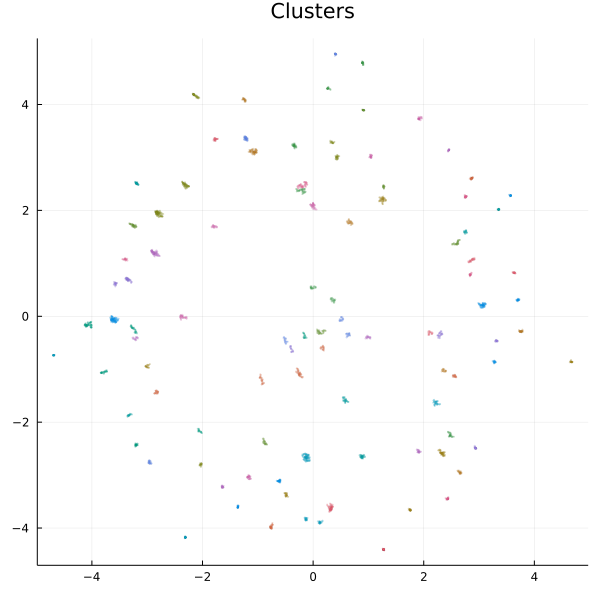

In [11]:
plot!(title="Clusters")


# Actividades
- Si usa Julia, revise el paquete `SimilaritySearch.jl`: <https://github.com/sadit/SimilaritySearch.jl> y <https://github.com/sadit/SimSearchManifoldLearning.jl>.
- Si usa Python, revise el paquete UMAP: <https://umap-learn.readthedocs.io/en/latest/>.
- Prepare la colección de `noticias` o el `emojispace` con la representación semántica basada en prototipos o la basada en nubes de puntos de las unidades anteriores, adicionalmente reproduzcalo para la representación basada en bolsa de palabras (primeras unidades del curso). Reproduzca las operaciones y el análisis de este notebook con estos datos.
- Reporte su notebook con una comparación de tiempos y calidadades.

# Bibliografía

- [@AW2019] Amid, E., & Warmuth, M. K. (2019). TriMap: Large-scale dimensionality reduction using triplets. arXiv preprint arXiv:1910.00204.
- [@LV2017] Lee, J. A., & Verleysen, M. (2007). Nonlinear dimensionality reduction (Vol. 1). New York: Springer.
- [@MHM2018] McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.
- [@SKL2011] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
- [@SPA2019] Soto, A. J., Przybyła, P., & Ananiadou, S. (2019). Thalia: semantic search engine for biomedical abstracts. Bioinformatics, 35(10), 1799-1801.
- [@SS2021] Sharma, K. K., & Seal, A. (2021). Spectral embedded generalized mean based k-nearest neighbors clustering with S-distance. Expert Systems with Applications, 169, 114326.
- [@VMH2018] Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11).
- [@YCC2020] Yu, Q., Chen, K. H., & Chen, J. J. (2020, September). Using a set of triangle inequalities to accelerate k-means clustering. In International Conference on Similarity Search and Applications (pp. 297-311). Springer, Cham.